#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim SomeCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [3]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

import bvcopula
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

animal = 'ST260'
dayN = 1
day_name = 'Day{}'.format(dayN)
path = '/home/nina/VRData/Processing/pkls'

with open("{}/{}_{}_signals.pkl".format(path,animal,day_name),'rb') as f:
    signal_pkl = pkl.load(f)
with open("{}/{}_{}_behaviour.pkl".format(path,animal,day_name),'rb') as f:
    behaviour_pkl = pkl.load(f)
for s in ['ROIsN','trialStart','maxTrialNum','trials']:
    assert(np.allclose(signal_pkl[s],behaviour_pkl[s]))
    
trials = behaviour_pkl['trials']

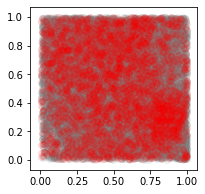

In [42]:
signals = signal_pkl['signals_transformed']
n1 = 2
n2 = -1
name1, name2 = f"Neuron {n1}", f"Neuron {n2}"
X,Y = utils.load_experimental_data(path, animal, day_name, n1, n2)

NSamp = X.shape[0]
plt.figure(figsize=(3,3))
colors = cm.rainbow(np.linspace(0., 1., NSamp))
skip = 5
#plt.scatter(*Y[::skip].T, color=colors[::skip], alpha=0.8)
plt.scatter(*Y[X<13/16].T,color='grey',alpha=0.1)
plt.scatter(*Y[(X>=13/16) & (X<14/16)].T,color='red',alpha=0.1)

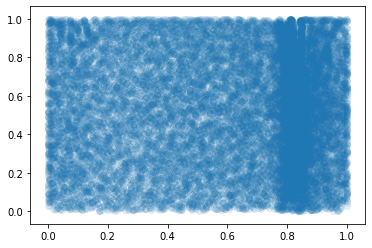

In [43]:
plt.scatter(X,Y[:,0],alpha=0.1)

/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/nina/.envs/GPyTorch_new/lib/python3.6/site-packages/seaborn/axisgrid.py:1741: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


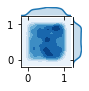

In [44]:
import seaborn as sns
mrg=0.2
g = sns.jointplot(*Y[(X>=140/160) & (X<160/160)].T, kind="kde", xlim=[-mrg,1+mrg], ylim=[-mrg,1+mrg],
                  size=1.1, shade=True,  shade_lowest=True, joint_kws = dict(cmap='Blues'), n_levels=6)#, cmap=cmap)
#g.savefig('figures/copula4.svg')

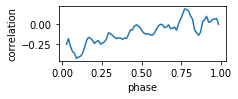

In [45]:
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import MI

X_pos = X.squeeze()*160
Y_pos = Y

ds = 2.0

x = np.linspace(0,1,int(160/ds))
p = np.empty(int(160/ds))
k = np.empty(int(160/ds))
ksg = np.empty(int(160/ds))

for b in range(int(160/ds)):
    dat = Y_pos[(X_pos>b*ds) & (X_pos<(b+1)*ds)]
    if len(dat)>1:
        p[b] = pearsonr(*dat.T)[0]
        k[b] = kendalltau(*dat.T)[0]
        
p = np.convolve(np.array(p), np.ones((4,))/4, mode='valid')    
    
g = plt.figure(figsize=(3,1))
plt.xlabel('phase')
plt.ylabel('correlation')
plt.plot(x[2:-1],p)
#plt.plot(x,k)

x=x[2:-1]
g.savefig('../results/fig/pearson.svg')

In [46]:
trial_weights = np.zeros_like(trials)
for i, v in enumerate(trials):
    trial_weights[i] = (len(trials)/trials[-1])*1./np.count_nonzero(trials==v)

In [47]:
likelihoods = [
    bvcopula.FrankCopula_Likelihood(),
#                 bvcopula.GaussianCopula_Likelihood(),
#                 bvcopula.ClaytonCopula_Likelihood(rotation='0°'),
                bvcopula.ClaytonCopula_Likelihood(rotation='90°'),
                #bvcopula.IndependenceCopula_Likelihood(),
#                 bvcopula.GumbelCopula_Likelihood(rotation='0°'),
#                 bvcopula.GumbelCopula_Likelihood(rotation='270°'),
                #GumbelCopula_Likelihood(rotation='0°'),
                ]

In [48]:
#convert numpy data to tensors (optionally on GPU)
device=1
train_x = torch.tensor(X,device=device).float()
train_y = torch.tensor(Y,device=device).float()
weights = torch.tensor(trial_weights,device=device).float()

In [49]:
waic, model = bvcopula.infer(likelihoods,train_x,train_y,device=device)

In [50]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,100)
test_x = torch.tensor(testX).float().cuda(device=device)

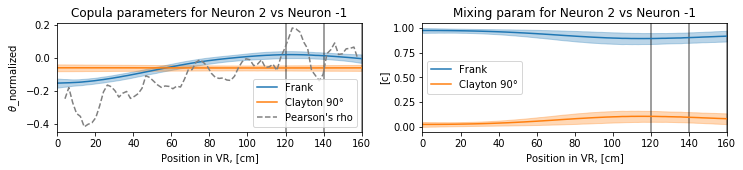

In [51]:
# visualize the result
fig, ax = plt.subplots(1,2,figsize=(12, 2))
    
for a in ax:
    a.axvline(120, color='black', alpha=0.5)
    a.axvline(140, color='black', alpha=0.5)
    a.axvline(160, color='black', alpha=0.5)    
    
utils.Plot_MixModel_Param_MCMC(ax,model,test_x,testX*160,rho=np.array([160*x,p]),title='for {} vs {}'.format(name1,name2))

plt.subplots_adjust(hspace=0.7)

fig.savefig(f"../results/fig/parameters_{n1}_{n2}.pdf")

In [52]:
# loglik, params = model.likelihood.WAIC(model(train_x), train_y, combine_terms=False)
# print(loglik, params, loglik-params)

In [53]:
s_mc_size=200
# S = torch.tensor(X).float().squeeze().to(device)
# subset = torch.randperm(torch.numel(S))[:s_mc_size]
# subset_S = S.view(-1)[subset]
#ignore prior over S
print(device)
S = torch.linspace(0,1,s_mc_size).to(device)
f_mc_size = 20
with torch.no_grad():
    Fs = model(S).rsample(torch.Size([f_mc_size])) 
    #[samples_f, copulas, stimuli(positions)]
    copula = model.likelihood(Fs) #[f, stimuli(positions)]
    H = copula.entropy(sem_tol=0.001)
    
    #MI,dMI,Hr,sem1=model.likelihood.stimMI(S,Fs,s_mc_size=200,r_mc_size=20,sR_mc_size=2000,sem_tol=5*1e-3)

1


In [54]:
MI_nl = -H.mean(dim=0).cpu().numpy()
dMI_nl = -H.std(dim=0).cpu().numpy()
# waic, model_l = bvcopula.infer([bvcopula.GaussianCopula_Likelihood()],train_x,train_y,device=device)
# with torch.no_grad():
#     Fs = model_l(S).rsample(torch.Size([f_mc_size])) 
#     #[samples_f, copulas, stimuli(positions)]
#     copula = model_l.likelihood(Fs) #[f, stimuli(positions)]
#     H = copula.entropy(sem_tol=0.001)
# MI_l = -H.mean(dim=0).cpu().numpy()
# dMI_l = -H.std(dim=0).cpu().numpy()

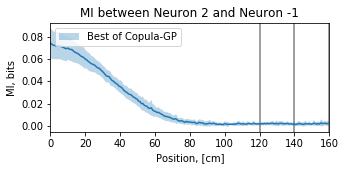

In [55]:
fig = plt.figure(figsize=(5, 2))
plt.axvline(120, color='black', alpha=0.5)
plt.axvline(140, color='black', alpha=0.5)
plt.axvline(160, color='black', alpha=0.5)
#mid = (ints[1:]+ints[:-1])/2*160
# n1,n2 = 3,63
# name1,name2 = f"{n1}",f"{n2}"
mid = 160*S.cpu()
# plt.plot(mid,MI_l)
# plt.fill_between(mid,(MI_l-dMI_l),(MI_l+dMI_l),alpha=0.3,label='Gaussian copula')#,label="MI={:.2}±{:.1}".format(MI,dMI))
plt.plot(mid,MI_nl)
plt.fill_between(mid,(MI_nl-dMI_nl),(MI_nl+dMI_nl),alpha=0.3,label='Best of Copula-GP')#,label="MI={:.2}±{:.1}".format(MI,dMI))
plt.title('MI between {} and {}'.format(name1,name2))
plt.legend(loc=2)
plt.xlabel('Position, [cm]')
plt.ylabel('MI, bits')
plt.xlim(0,160)
fig.savefig(f"../results/fig/MI_{n1}_{n2}.pdf")

In [36]:
# mid = (ints[1:]+ints[:-1])/2*160
# plt.figure(figsize=(5.2,2.5))
# def plot_MIs(MIs,label):
#     plt.plot(mid,MIs[:,0])
#     plt.fill_between(mid,MIs[:,0]-2*MIs[:,1],MIs[:,0]+2*MIs[:,1],alpha=0.3,label=label)
# #plot_MIs(MIsd,'Diff')
# plot_MIs(MIs_base,'Gaussian model')
# plot_MIs(MIs_all,'Mixed copula model')
# #plot_MIs(MIs_nolick,'No LR')
# plt.axhline(0)
# plt.xlabel('Position, [cm]')
# plt.ylabel('Mutual Infromation, [bit]')
# plt.title('MI between Neuron 12 & Background')
# plt.legend()

In [37]:
# plt.rcParams.update({'font.size': 12})

# ds = 2.5
# n = int(160/ds)

# FI_all, MIp_all = model.likelihood.input_information(model,train_y,n,160.)

# plt.plot(np.arange(n+1)*ds,FI.detach().cpu().numpy(),label='Fisher information')
# plt.plot(0,0,color='white',label='MI_pos = {:.1f} bits'.format(MI.detach().cpu().numpy()/np.log(2)))
# plt.title("{} vs. {}".format(name1,name2))
# plt.xlabel('Position, [cm]')
# plt.ylabel('FI, nat')
# plt.ylim(0,40)
# plt.legend()

In [38]:
# define test set (optionally on GPU)
testX = np.repeat(X,1)
test_x = torch.tensor(testX).float().cuda(device=device)
#generate some samples
model.eval()
with gpytorch.settings.num_likelihood_samples(1):
    gplink = model.likelihood.gplink_function
    copulas = [lik.copula for lik in likelihoods]
    rotations = [lik.rotation for lik in likelihoods]
    thetas, mixes = gplink(model(test_x).mean)
    test_y = model.likelihood.copula(thetas,mixes,copulas,rotations=rotations).rsample()
    Y_sim = test_y.cpu().detach().numpy()

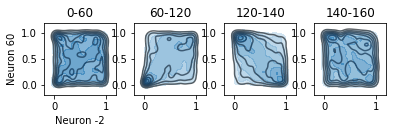

In [39]:
# visualize the result
fig = plt.figure(figsize=(5, 2))

# top_axes = (fig.add_axes([0,0.7,0.45,1]),fig.add_axes([0.5,0.7,0.45,1]))
bottom_axes = np.array([fig.add_axes([0,0,0.2,0.5]),
               fig.add_axes([0.25,0,0.2,0.5]),
               fig.add_axes([0.5,0,0.2,0.5]),
               fig.add_axes([0.75,0,0.2,0.5])])
    
# for a in top_axes:
#     a.axvline(120, color='black', alpha=0.5)
#     a.axvline(140, color='black', alpha=0.5)
#     a.axvline(160, color='black', alpha=0.5)    
    
# utils.Plot_MixModel_Param_MCMC(top_axes,model,test_x,testX*160,rho=np.array([x,p]),title=' for {} vs {}'.format(name1,name2))

plt.subplots_adjust(hspace=0.5)

bottom_axes[0].set_ylabel(name2)
bottom_axes[0].set_xlabel(name1)

interval_ends = [0,60,120,140,160]
utils.Plot_Copula_Density(bottom_axes, testX.squeeze()*160, Y_sim.squeeze(), interval_ends, shade=True)
utils.Plot_Copula_Density(bottom_axes, X.squeeze()*160, Y, interval_ends, shade=False, color='#073763ff')

plt.subplots_adjust(wspace=0.5)
fig.savefig(f"../results/fig/densities_{n1}_{n2}.pdf")

In [40]:
data = {}
data['n1'] = n1
data['n2'] = n2
data['X'] = X
data['Y'] = Y
data['Xs'] = testX
data['Ys'] = Y_sim
data['x'] = x
data['p'] = p
data['MI'] = [mid,MI_nl,dMI_nl]
data['likelihoods'] = likelihoods
with open(f"{home}/results/ex_{n1}_{n2}.pkl","wb") as f:
    pkl.dump(data,f)

In [31]:
n2

23